%pip install torchtext
%pip install wandb

In [1]:
import pandas as pd
import torch
import torchvision
from PIL import Image, ImageFile
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nltk
nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
data = data.sample(frac=1).reset_index(drop=True)
data = data[:20000]
data = data.rename(columns={'FILE':'image','URL':'description'})
data = data[['image','description']]
data['image'] = [f'.{x}' for x in data['image']]
print(f'columns:{[x for x in data.columns]}')

columns:['image', 'description']


In [3]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

100%|██████████| 20000/20000 [04:06<00:00, 81.04it/s]


In [4]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4576, 0.3407, 0.2236])
Std of the image: tensor([0.2554, 0.2206, 0.1634])


In [5]:
# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(data['image'],data['description'], test_size=0.2, random_state=42)
print(f'Train size:{len(X_train)} Val size:{len(y_train)}')

Train size:16000 Val size:16000


In [6]:
#Image Transformations
img_train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

img_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

# Vocabulary Class Explanation

## Introduction
This code defines a Python class called `Vocabulary` which is designed to create and manage a vocabulary for natural language processing tasks.

## Class Initialization
- The `Vocabulary` class is initialized with a name.
- It initializes three tokens (`PAD_token`, `SOS_token`, `EOS_token`) which are used for padding short sentences, marking the start of a sentence, and marking the end of a sentence respectively.
- It initializes dictionaries to store mappings between words and indices, and vice versa.
- It also tracks the number of words, sentences, and the length of the longest sentence.

## Method: add_word
- This method adds a word to the vocabulary.
- If the word is not already in the vocabulary, it assigns it a unique index and initializes its count to 1.
- If the word already exists in the vocabulary, it simply increments its count.

## Method: add_sentence
- This method adds a sentence to the vocabulary.
- It splits the sentence into words, adds each word using the `add_word` method, and updates the length of the longest sentence.
- It also increments the count of sentences.

## Method: to_word
- This method converts an index to its corresponding word in the vocabulary.

## Method: to_index
- This method converts a word to its corresponding index in the vocabulary.

## Method: len
- This method returns the total number of words in the vocabulary.

## Usage
- After defining the `Vocabulary` class, an instance of it named `vocab` is created with the name 'art'.
- Then, it iterates through sentences (presumably contained in a variable called `data['description']`), tokenizes each sentence into words using NLTK's `word_tokenize` function, and adds each word to the vocabulary using the `add_word` method.

In [7]:
from nltk.tokenize import word_tokenize
class Vocabulary:
    
    def __init__(self, name):
        self.name = name
        PAD_token = 0   # Used for padding short sentences
        SOS_token = 1   # Start-of-sentence token
        EOS_token = 2   # End-of-sentence token
        self.word2index = {"PAD": PAD_token, "SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]
    
    def len(self):
        return self.num_words

vocab = Vocabulary('art')
for sentence in tqdm(data['description']):
    sentence = word_tokenize(sentence)
    for word in sentence:
        vocab.add_word(word)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:08<00:00, 2326.25it/s]


# ArtDataset Class Explanation

## Introduction
This code defines a custom dataset class `ArtDataset` for handling image and caption data. It's designed to be compatible with PyTorch's `torch.utils.data.Dataset` class.

## Class Initialization
- The `ArtDataset` class is initialized with image data, corresponding labels (captions), an optional transformation for images, and a maximum caption length.
- It stores these parameters as attributes for later use.

## Method: __len__
- This method returns the length of the dataset, which is the number of samples (images) in the dataset.

## Method: __getitem__
- This method is used to retrieve a single item (image and caption pair) from the dataset given an index.
- It loads the image corresponding to the index using PIL's `Image.open` function and converts it to RGB format.
- If a transformation is provided, it applies the transformation to the image.
- It tokenizes the caption using NLTK's `word_tokenize` function, appending start-of-sentence (`SOS`) and end-of-sentence (`EOS`) tokens to the tokenized caption.
- If the length of the tokenized caption exceeds the maximum caption length, it truncates it; otherwise, it pads it with `PAD` tokens to match the maximum length.
- It then converts the tokens to indices using a predefined vocabulary (`vocab`) and creates a PyTorch tensor from the indices.
- Finally, it returns a tuple containing the processed image and the tokenized caption.

## Dataset Instantiation
- After defining the `ArtDataset` class, two instances of it (`train_dataset` and `test_dataset`) are created using training and validation data (`X_train`, `y_train`, `X_val`, `y_val`), respectively.
- From the `train_dataset` a validation dataset is further extracted.
- Transformation functions (`img_train_transform` and `img_test_transform`) are applied to the images if provided.



In [8]:
from nltk.tokenize import word_tokenize
class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,images,labels,transform=None, max_caption_length=50):
        self.data = images
        self.labels = labels
        self.transform = transform
        self.max_caption_length = max_caption_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_pil = Image.open(self.data[index])
        img_pil = img_pil.convert('RGB')
        if self.transform is not None:
            img_pil = self.transform(img_pil)
        else:
            tr1 = transforms.ToTensor()
            img_pil = tr1(img_pil)

        #Tokenize caption using nltk
        caption = self.labels[index]
        tokens = []
        tokens.append('SOS')
        tokens.extend(word_tokenize(caption))
        tokens.append('EOS')
        if len(tokens) > self.max_caption_length:
            tokens = tokens[:self.max_caption_length]
        else:
            tokens += ["PAD"] * (self.max_caption_length - len(tokens))
        #Convert tokens to indices
        caption = [vocab.to_index(token) for token in tokens]

        tokenized_caption = torch.LongTensor(caption)
        return(img_pil,tokenized_caption)

train_dataset = ArtDataset(X_train[:13500].values,y_train[:13500].values,transform=img_train_transform)
val_dataset = ArtDataset(X_train[13500:].values,y_train[13500:].values,transform=img_test_transform)
test_dataset = ArtDataset(X_val.values,y_val.values,transform=img_test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: 32


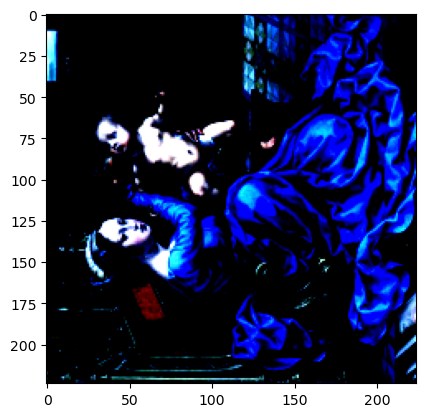

In [9]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze()
plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()

In [10]:
del data
del X_train,X_val,y_train,y_val

## Encoder Explanation

The `Encoder` class is responsible for extracting meaningful features from input data, typically images, and transforming them into a format suitable for further processing by the decoder.

### Initialization
- **Embedding Dimension (`embed_dim`)**: This parameter specifies the dimensionality of the output feature vectors produced by the encoder.
- **Batch Normalization Momentum (`batch_norm_momentum`)**: Momentum value used for batch normalization.
- **Dropout Probability (`dropout`)**: Dropout probability for regularization.

### Components
1. **DenseNet-201 Backbone**: The encoder utilizes the DenseNet-201 architecture, a deep convolutional neural network pre-trained on the ImageNet dataset. DenseNet-201 consists of densely connected blocks, enabling feature reuse and efficient feature propagation.
2. **Freezing Pre-trained Weights**: The parameters of the DenseNet-201 backbone are frozen (`requires_grad = False`), preventing them from being updated during training to retain the learned features.
3. **Linear Layer (`embed`)**: Adjusts the output features from the DenseNet-201 classifier to the desired embedding dimension (`embed_dim`). This layer reduces the dimensionality of the feature vectors.
4. **Batch Normalization (`batch`)**: Applies batch normalization to normalize the output features and improve training stability. It adjusts the mean and variance of each feature dimension.
5. **Dropout Layer**: Randomly drops a fraction of the input features during training to prevent overfitting and improve generalization.
6. **Initialization**: Weights of the linear layer are initialized with normal distribution (mean=0, standard deviation=0.1), and bias is initialized to zeros.

### Forward Pass
- **Input Processing**: Takes images (`imgs`) as input.
- **Feature Extraction**: Passes the input images through the DenseNet-201 backbone to extract high-level features. The DenseNet architecture efficiently captures spatial hierarchies in the images.
- **Dropout Regularization**: Applies dropout to the extracted features to prevent overfitting by randomly setting a fraction of the features to zero during training.
- **Dimensionality Reduction**: Projects the extracted features to the desired embedding dimension using a linear layer. This step reduces the dimensionality of the feature vectors while preserving relevant information.
- **Batch Normalization**: Normalizes the output features using batch normalization, ensuring stable training by scaling and shifting the features.
- **Output**: Returns the processed features as the output of the encoder.

### Summary
The `Encoder` class employs the DenseNet-201 architecture to extract informative features from input images. By reducing dimensionality, applying batch normalization, and employing dropout regularization, the encoder prepares the features for further processing by the decoder, facilitating the generation of accurate and descriptive captions.


In [11]:
from torchvision.models.densenet import DenseNet201_Weights
class Encoder(nn.Module):
    def __init__(self, embed_dim, batch_norm_momentum=0.9, dropout=0.5) -> None:
        super(Encoder,self).__init__()
        # resnet = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT")
        # resnet = torchvision.models.resnext101_64x4d(pretrained=True)
        self.dense_net = torchvision.models.densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)
        for param in self.dense_net.parameters():
            param.requires_grad = False
        
        #Adjusting the output features according to the embed_dim
        self.embed = nn.Linear(self.dense_net.classifier.out_features,embed_dim)
        self.batch = nn.BatchNorm1d(embed_dim,momentum=batch_norm_momentum)
        self.dropout = nn.Dropout(dropout)

        #Initializing the weights and bias
        self.embed.weight.data.normal_(0.0,0.1)
        self.embed.bias.data.fill_(0)


    def forward(self,imgs):
        features = self.dense_net(imgs)
        features = self.dropout(features)
        features = self.embed(features)
        features = self.batch(features)
        
        return features

## Attention Explanation

The `Attention` class enables the model to selectively focus on different parts of the input sequence (or image features) when generating each element of the output sequence.

### Initialization
- **Encoder Dimension (`encoder_dim`)**: The dimensionality of the encoder output features.
- **Decoder Dimension (`decoder_dim`)**: The dimensionality of the decoder hidden states.
- **Attention Dimension (`attention_dim`)**: The dimensionality of the attention mechanism.

### Components
1. **Linear Layers**: The attention mechanism consists of three linear transformations:
   - `encoder_att`: Projects the encoder output features to the attention dimension.
   - `decoder_att`: Projects the decoder hidden states to the attention dimension.
   - `full_att`: Projects the concatenated attention vectors to a single value, representing the attention score.

2. **Forward Pass**:
   - **Encoder Attention**: Projects the encoder output features (`encoder_out`) using the `encoder_att` linear layer.
   - **Decoder Attention**: Projects the decoder hidden state (`decoder_hidden`) using the `decoder_att` linear layer and adds a singleton dimension.
   - **Combination**: Combines the projected encoder and decoder attention vectors and applies the Rectified Linear Unit (ReLU) activation function to obtain the attention scores.
   - **Attention Score**: Projects the combined attention vectors using the `full_att` linear layer and squeezes the resulting tensor to obtain a single attention score for each element in the input sequence.
   - **Attention Weights**: Applies the softmax function along the sequence dimension to obtain the attention weights (`alpha`). These weights represent the importance of each input feature at the current decoding step.
   - **Weighted Sum**: Computes the weighted sum of the encoder output features using the attention weights to obtain the attention-weighted encoding (`attention_weighted_encoding`).

### Summary
The `Attention` class enables the model to dynamically focus on different parts of the input sequence (or image features) during the decoding process. By assigning higher weights to relevant features and lower weights to less relevant ones, the attention mechanism enhances the model's ability to generate accurate and contextually relevant outputs.


In [12]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim) -> None:
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)#U
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)#W
        self.full_att = nn.Linear(attention_dim,1)#V
        

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1) # W * decoder_hidden
        att = F.relu(att1+att2) # ReLU(U * encoder_out + W * decoder_hidden)
        att = self.full_att(att).squeeze(2) # V * ReLU(U * encoder_out + W * decoder_hidden)
        alpha = F.softmax(att, dim=1) # attention weights
        attention_weighted_encoding = torch.sum(encoder_out * alpha,dim=1).squeeze(1) # attention_weighted_encoding

        return attention_weighted_encoding, alpha

## Decoder Explanation

The `Decoder` class take the encoded image features, often extracted by the encoder, and transform them into descriptive text captions.

### Initialization
- **Embedding Size (`embed_size`)**: This parameter defines the size of the word embedding vectors. Word embeddings are dense, continuous-valued representations of words in a vector space.
- **Hidden Size (`hidden_size`)**: This parameter specifies the size of the hidden state in the LSTM (Long Short-Term Memory) layer. The hidden state captures information from previous time steps.
- **Vocabulary Size (`vocab_size`)**: The size of the vocabulary, i.e., the total number of unique words in the language.
- **Dropout Probability (`dropout`)**: Dropout is a regularization technique that randomly sets a fraction of input units to zero during training to prevent overfitting.

### Components
1. **Attention Mechanism**: The decoder utilizes an attention mechanism to selectively focus on different regions of the input image features while generating captions. This allows the model to attend to relevant parts of the image during each step of caption generation.
2. **Embedding Layer**: Converts word indices into dense vectors of fixed size (`embed_size`). This layer essentially learns the semantic representations of words based on their context in the captions.
3. **LSTM Layer**: The LSTM processes sequential input data and maintains hidden states across time steps. It takes embedded word vectors as input and produces output sequences. The hidden state captures context information and helps in capturing long-range dependencies.
4. **Linear Layer**: Maps the output of the LSTM to a space with dimensionality equal to the vocabulary size. This layer produces logits for each word in the vocabulary, representing the likelihood of each word being the next word in the sequence.
5. **Sigmoid Layer**: A sigmoid function used to compute the gating mechanism for attention. It helps in controlling the attention mechanism, determining the relevance of different parts of the image features.
6. **Initialization**: Weights for the embedding and linear layers are initialized within a certain range to ensure effective learning during training.

### Forward Pass
- **Input Processing**: Takes image features (`features`) and ground truth captions (`captions`) as inputs.
- **Embedding and Concatenation**: Embeds the captions using the embedding layer and concatenates them with the image features. This combined representation is used as input for subsequent processing.
- **LSTM Computation**: Passes the concatenated input through the LSTM, computing attention-weighted encoding. This step captures the contextual information from both the image features and the previously generated words in the captions.
- **Attention Mechanism**: Applies a gating mechanism to the attention-weighted encoding, determining the importance of different parts of the image features in generating the next word.
- **Output Generation**: Generates logits for each word in the vocabulary using a linear layer. These logits represent the model's confidence in predicting each word in the vocabulary.
- **Regularization**: Applies dropout regularization to the output sequence to prevent overfitting during training.

### Sampling Methods
- **Greedy Sampling (`sample`)**: Selects the word with the highest probability at each time step to form the sequence. This method tends to produce coherent but potentially repetitive captions.
- **Combined Sampling (`sample_combined_search`)**: Combines the sampling from top-k and nucleus sampling methods to enhance diversity and reduce repetition in the generated captions. 
- **Top-k Sampling (`top_k_sampling`)**: Samples from the top k most likely words at each time step, enhancing diversity in the generated captions.
- **Nucleus Sampling (`nucleus_sampling`)**: Samples from the set of words whose cumulative probability mass exceeds a certain threshold (`p`). This method promotes diversity while controlling the number of possible words sampled.

### Summary
The `Decoder` class is a fundamental component of image captioning models, responsible for converting visual information into textual descriptions. Through a combination of attention mechanisms, recurrent neural networks, and sampling techniques, the decoder effectively generates captions that capture the essence of the input images.


In [13]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size,dropout=0.5):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.attention = Attention(embed_size, hidden_size, hidden_size)

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.f_beta = nn.Linear(hidden_size, embed_size)
        self.sigmoid = nn.Sigmoid()

        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings[:,:-1,:]), dim=1)
        hidden, _ = self.lstm(embeddings)
        attention_weighted_encoding, _ = self.attention(features, hidden)
        gate = self.sigmoid(self.f_beta(hidden))
        attention_weighted_encoding = gate * attention_weighted_encoding
        # inputs = torch.cat((embeddings[:, :-1, :], attention_weighted_encoding), dim=1) #Combined lstm output and attention weighted encoding in a single tensor, reduces the number of LSTM iterations.
        inputs = torch.cat((embeddings,attention_weighted_encoding))
        lstm_out, _ = self.lstm(inputs)
        
        outputs = self.linear(self.dropout(lstm_out))
        
        return outputs
    
    def sample(self,features, max_len=50):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        states = None

        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)          
            outputs = self.linear(hiddens)
            out = outputs.squeeze(1)    
            predicted = torch.argmax(out,dim=1)
            sampled_ids.append(predicted.cpu().numpy()[0].item())
            inputs = self.embedding(predicted).unsqueeze(1)                 
        # sampled_ids = torch.stack(sampled_ids,1)
        return sampled_ids
    
    #Top-k + Nucleus Sampling
    def sample_combined_search(self, features, max_len=50, temperature=1.0, top_k=0, top_p=0.0):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        states = None
        
        for _ in range(max_len):
            hiddens, states= self.lstm(inputs, states)
            outputs = self.linear(hiddens)/temperature
            if top_k > 0:
                outputs = self.top_k_sampling(outputs, top_k)
            elif top_p < 1.0:
                outputs = self.nucleus_sampling(outputs,top_p)
            out = outputs.squeeze(1)    
            predicted = torch.argmax(out,dim=1)
            sampled_ids.append(predicted.cpu().numpy()[0].item())
            inputs = self.embedding(predicted).unsqueeze(1) 
        # sampled_ids = torch.stack(sampled_ids,1)
        return sampled_ids

#Operates directly on logits and not softmax probabilities
    def top_k_sampling(self, logits, k):
        with torch.no_grad():
            top_values, _ = torch.topk(logits, k, dim=-1)
            min_value = top_values[:, -1].unsqueeze(-1)
            logits = torch.where(logits < min_value, torch.tensor(-float('inf'), device=logits.device), logits)
        return logits

    def nucleus_sampling(self, logits, p):
        with torch.no_grad():
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = 0
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[indices_to_remove] = -float('inf')
        return logits


In [14]:
class ArtModel(nn.Module):
    def __init__(self,embed_size,hidden_size, vocab_size, batch_norm_momentum=0.9, dropout=0.5):
        super(ArtModel,self).__init__()
        self.encoder = Encoder(embed_size, batch_norm_momentum=batch_norm_momentum, dropout=dropout)
        self.decoder = Decoder(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size,dropout=dropout)

    def forward(self,imgs,captions):
        features = self.encoder(imgs)
        outputs = self.decoder(features,captions)
        return outputs

    def sample(self,imgs,max_len=50):
        features = self.encoder(imgs)
        sampled_ids = self.decoder.sample(features,max_len)
        return sampled_ids

    def sample_combined_search(self,imgs,max_len=50,temperature=1.0,top_k=1,top_p=0.9):
        features = self.encoder(imgs)
        sampled_ids = self.decoder.sample_combined_search(features,max_len,temperature,top_k,top_p)
        return sampled_ids

# `train` Function Explanation

## Introduction
This function is responsible for training the Show and Tell model using the provided data and optimizer.

## Function Parameters
- `train_loader`: The data loader for training images and captions.
- `encoder`: The encoder model responsible for extracting image features.
- `decoder`: The decoder model responsible for generating captions.
- `criterion`: The loss function used to compute the training loss.
- `encoder_optimizer`: The optimizer used to update the parameters of the encoder model (can be `None` if the encoder is frozen).
- `decoder_optimizer`: The optimizer used to update the parameters of the decoder model.
- `epoch`: The current epoch number.

## Training Loop
- The function iterates over the batches of training data provided by `train_loader`.
- For each batch:
  - It moves the images and captions to the appropriate device (CPU or GPU).
  - It computes the lengths of the captions in the batch.
  - It passes the images through the encoder to obtain image features.
  - It passes the image features and captions through the decoder to obtain predicted scores for each word in the captions.
  - It packs the predicted scores and the ground truth captions using `pack_padded_sequence` to handle variable-length sequences.
  - It computes the loss between the predicted scores and the ground truth captions using the provided loss function (`criterion`).
  - It backpropagates the loss and updates the parameters of the decoder (and optionally the encoder) using the specified optimizers (`decoder_optimizer` and `encoder_optimizer`).
  - It logs the current loss for monitoring training progress.
  - It updates the progress bar with information about the current epoch, batch number, and loss.

## Logging
- We log the training loss for each batch to monitor the training progress.
- We update the progress bar to display the current epoch, batch number, and loss information.
- We return the Training loss and validation loss for each epoch.

In [15]:
def train(model,encoder_optimizer, decoder_optimizer, criterion, train_loader, val_loader, epochs=10, early_stopping_patience=25):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    #Train the model
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            model.encoder.train()
            model.decoder.train()
            train_loss = 0.0
            for _, (images, captions) in enumerate(train_loader,0):
                images, captions = images.to(device), captions.to(device)
                encoder_optimizer.zero_grad() if encoder_optimizer else None
                decoder_optimizer.zero_grad()
                
                outputs = model(images, captions)

                #Flatten the outputs and the captions
                decode_lengths = [len(cap) for cap in captions]
                outputs = nn.utils.rnn.pack_padded_sequence(outputs, decode_lengths, batch_first=True, enforce_sorted=False)
                captions = nn.utils.rnn.pack_padded_sequence(captions, decode_lengths, batch_first=True, enforce_sorted=False)

                loss = criterion(outputs.data,captions.data)
                
                loss.backward()
                encoder_optimizer.step() if encoder_optimizer else None
                decoder_optimizer.step()

                train_loss += loss.item()

            train_losses.append(train_loss/len(train_loader))

            #Validation of the model
            model.encoder.eval()
            model.decoder.eval()
            val_loss = 0.0
            with torch.no_grad():
                for img,captions in val_loader:
                    img,captions = img.to(device),captions.to(device)

                    outputs = model(img,captions)
                    
                    decode_lengths = [len(cap) for cap in captions]
                    outputs = nn.utils.rnn.pack_padded_sequence(outputs, decode_lengths, batch_first=True, enforce_sorted=False)
                    captions = nn.utils.rnn.pack_padded_sequence(captions, decode_lengths, batch_first=True, enforce_sorted=False)
                    loss = criterion(outputs.data,captions.data)
                    val_loss += loss.item()
            val_losses.append(val_loss/len(val_loader))

            #Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print(f'Early stopping! Epoch: {epoch+1}')
                    break

            pbar.set_description(f'Train Loss: {train_losses[-1]:.3f} | Val Loss: {val_losses[-1]:.3f}')
            pbar.update(1)

    return train_losses, val_losses

In [16]:
import matplotlib.pyplot as plt

def plot_loss(loss_values, title="Loss Plot"):
    """
    Plot the loss values over training epochs.

    Parameters:
    - loss_values: A list or array of loss values for each epoch.
    - title: The title of the plot (optional).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values[0], marker='o', linestyle='-', label='train')
    plt.plot(loss_values[1], marker='o', linestyle='-',label='val')
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# `convert_to_words` Function Explanation

## Introduction
This function converts the predicted word indices generated by the decoder into actual words using the vocabulary mapping.

## Function Parameters
- `sampled_ids`: A list of predicted word indices generated by the decoder.

## Conversion Process
- The function iterates over the predicted word indices (`sampled_ids`).
- For each word index, it retrieves the corresponding word from the vocabulary using the `index2word` mapping.
- It appends the word to the `sampled_caption` list.
- If the word is 'EOS' (end-of-sentence token), it stops the iteration as the caption is complete.
- Finally, it joins the words in the `sampled_caption` list to form the final caption sentence.

## Summary
This function plays a crucial role in converting the output of the decoder (predicted word indices) into human-readable captions. It utilizes the vocabulary mapping (`index2word`) to perform the conversion, enabling the model to generate descriptive captions for images.


In [17]:
#Define the function to convert the predicted ids to words
def convert_to_words(sampled_ids):
    sampled_caption = []
    for word_id in sampled_ids:
        word_id = int(word_id)
        word = vocab.index2word[word_id]
        sampled_caption.append(word)
        if word == 'EOS':
            break
    sentence = ' '.join(sampled_caption)
    return sentence

In [18]:
#Define the prediction function
def predict(model,image, top_k, top_p, max_len=50, temperature=1.0):
    model.encoder.eval()
    model.decoder.eval()
    image = image.to(device)
    sampled_ids = []
    sampled_ids = model.sample_combined_search(image, max_len=max_len, temperature=temperature, top_k=top_k, top_p=top_p)
    return sampled_ids

# `rouge_score` Function Explanation

## Introduction
This function computes the ROUGE (Recall-Oriented Understudy for Gisting Evaluation) score for the generated captions by the Show and Tell model on the validation dataset.

## Function Parameters
- `testloader`: The data loader for validation images and captions.
- `encoder`: The encoder model used for feature extraction.
- `decoder`: The decoder model used for caption generation.

## ROUGE Score Computation
- The function imports the `load_metric` function from the `datasets` library, which is used to load the ROUGE metric.
- It sets the encoder and decoder models to evaluation mode using the `eval()` method.
- The function iterates over the batches of validation data provided by `testloader`.
- For each batch:
  - It moves the images to the appropriate device (CPU or GPU).
  - It extracts features from the images using the encoder.
  - It generates captions for the images using the decoder's `sample_combined_search` method, which combines `top_k` and `nucleus` sampling.
  - It converts the indices of the generated captions to actual words using the vocabulary (`vocab`).
  - It adds the generated captions and ground truth captions to the ROUGE metric using the `add` method.
- Finally, the function computes the ROUGE score using the `compute` method of the ROUGE metric.

## ROUGE Score
- The ROUGE score is a metric commonly used to evaluate the quality of machine-generated text summaries. It measures the overlap of n-grams (typically up to 4-grams) between the generated captions and the reference captions, focusing on recall rather than precision.

## Summary
This function evaluates the quality of the generated captions by computing the ROUGE score, providing a quantitative measure of the model's performance in generating captions that capture the essence of the ground truth captions.



In [19]:
from datasets import load_metric

def rouge_score(model, data_loader, top_p, top_k):
    rouge = load_metric('rouge')
    predictions = []
    references = []
    for img, label in data_loader: 
        res = predict(model, img, top_k=top_k, top_p=top_p)
        sentence = convert_to_words(res)
        predictions.append(sentence)
        references.append(label)
    result = rouge.compute(predictions=predictions, references=references, use_aggregator=True)
    return result


### Optimizing the Model with Optuna

In [20]:
# import optuna

# def objective(trial):
#     # Define search space for hyperparameters
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1,log=True)
#     batch_size = trial.suggest_categorical('batch_size', [32, 64])
#     early_stopping_patience = trial.suggest_int('early_stopping_patience', 5, 25)
#     weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
#     dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
#     top_k = trial.suggest_categorical('top_k', [0, 1])
#     top_p = trial.suggest_float('top_p', [0.0, 0.9])

#     # Train the model with current hyperparameters

#     encoder = Encoder(embed_dim=512).to(device)
#     decoder = Decoder(embed_size=512, hidden_size=512, vocab_size=vocab.len(),dropout=dropout_rate).to(device)
#     optimizer_encoder = torch.optim.AdamW(encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer_decoder = torch.optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     criterion = nn.CrossEntropyLoss()
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#     _,val_loss = train(encoder, decoder, optimizer_encoder, optimizer_decoder, criterion, train_loader, val_loader, epochs=30, early_stopping_patience=early_stopping_patience)
#     accuracy = rouge_score(encoder, decoder, val_loader, top_p=top_p, top_k=top_k)
#     return accuracy

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get the best hyperparameters and accuracy
# best_params = study.best_params
# best_accuracy = study.best_value

# print("Best hyperparameters Author:", best_params)
# print("Best accuracy Author:", best_accuracy)

## Train and Hyperparams

In [21]:
#Parameters and Hyperparameters
#Model Parameters
embed_dim = 400
decoder_dim = 224
dropout = 2.9e-01
batch_norm_momentum = 0.9

#Training Hyperparameters
epochs = 100
encoder_lr = 1.9e-03
decoder_lr = 1.9e-03
weight_decay = 2.28e-06
fine_tune_encoder = False
checkpoint = None


In [22]:
model = ArtModel(embed_size=embed_dim,hidden_size=decoder_dim,vocab_size=vocab.len(),batch_norm_momentum=batch_norm_momentum,dropout=dropout).to(device)

parameters = list(model.decoder.parameters())+list(model.encoder.embed.parameters())
decoder_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, parameters), lr=decoder_lr, weight_decay=weight_decay)
encoder_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.encoder.parameters()), lr=encoder_lr, weight_decay=weight_decay) if fine_tune_encoder else None
 
criterion = nn.CrossEntropyLoss()
train_loss, val_loss = train(model,encoder_optimizer,decoder_optimizer,criterion,trainloader,valloader,epochs=epochs, early_stopping_patience=15)

Train Loss: 1.505 | Val Loss: 4.659:  21%|██        | 21/100 [1:32:09<5:46:40, 263.30s/it]

Early stopping! Epoch: 22


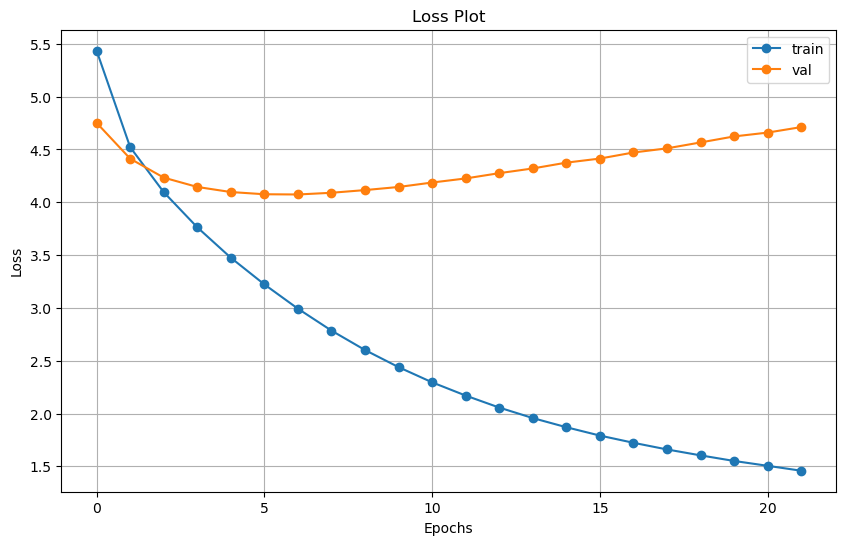

In [23]:
plot_loss([train_loss,val_loss])

In [30]:
results = rouge_score(model,testloader,top_p=0.9,top_k=1)
print(f"Rouge Score: {results}")

C:\Users\Fede\AppData\Local\Temp\ipykernel_17884\380951606.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')


Rouge Score: 5.5448659600746935e-05


In [31]:
   #Define the function to display the image and the predicted caption
def display_image_caption(image,sentence):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(sentence)
    plt.show()

In [32]:
#Define the function to display the image and the actual caption
def display_image_caption_actual(image, label):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(convert_to_words(tuple(label.numpy())))
    plt.show()

Predicted: SOS The painting is signed and dated lower left : P. J. LOTHERBOURG / 1777 . EOS


Predicted: SOS The painting is signed and dated lower left : P. J. LOTHERBOURG / 1777 . EOS


Predicted: SOS The picture shows the left wing of the Portinari Triptych.Three members of the Portinari family , Tommaso Portinari and his wife , and the donor , John the Baptist , and the Sermon at the Jordan on the right . On the left , St John the Baptist , is shown in the background . EOS


Predicted: SOS The picture shows the fresco before the restoration completed in 2002 . EOS


Predicted: SOS The painting is signed and dated lower left : P. J. LOTHERBOURG / 1777 . EOS


Predicted: SOS The painting is signed and dated lower left : P. J. LOTHERBOURG / 1777 . EOS


Predicted: SOS The picture shows the frontispiece of the Statute and Register of the Moneychangers ' Guild . Beneath the picture , with a group of figures grouped around the foreground , a symbol of the Virgin and Child . EOS


Predicted: SOS The picture shows the left side of the painting . EOS


Predicted: SOS This painting is a fragment of a larger composition . EOS


Predicted: SOS The picture shows the Betrothal of Maximilian of the Medici ( 300 x 118 cm ) and the Grand Canal , with the church of the Scalzi ( church of Santa Maria di Nazareth ) . EOS
Predicted: SOS The picture shows the fresco before the restoration completed in 2002 . EOS


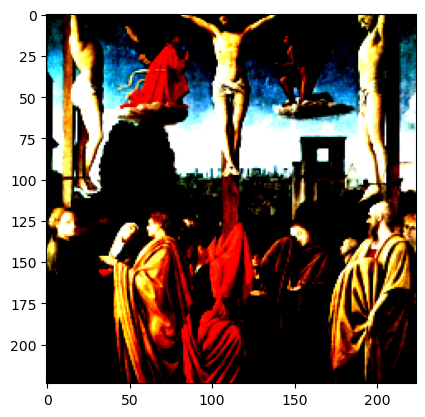

In [34]:

#img, label = next(iter(testloader))
for i, (img, label) in enumerate(testloader):
    # display_image_caption_actual(img[:1], label[:1])
    plt.imshow(img.squeeze().permute(1,2,0))
    img = img.to(device)
    res = predict(model,img, top_k=1, top_p=0.5, max_len=500, temperature=0.5)
    sentence = convert_to_words(res)
    print(f"Predicted: {sentence}")
    if i == 10:
        break

In [36]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
torch.save(model.state_dict(), './model_checkpoints/model_capt.pth')